Title - Classifying data using pretrained models/transfer learning.

Transfer learning is a powerful technique used in deep learning to leverage pre-trained models and adapt them to solve new tasks with limited data. The provided code demonstrates an example of transfer learning using the InceptionV3 model, pre-trained on the ImageNet dataset, to classify flower images into five different classes: daisy, dandelion, rose, sunflower, and tulip.

Here are the main steps and key points in the provided code:

Importing Libraries: The necessary libraries for building and training the model are imported, including TensorFlow, Keras, and other utility modules.

Dataset Preparation: The flower dataset is loaded using the ImageDataGenerator, which provides efficient data augmentation and preprocessing techniques. The dataset is split into training and validation sets.

Pre-trained Model: InceptionV3, a pre-trained CNN architecture, is loaded without the fully connected layers (include_top=False) and initialized with weights obtained from the "inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5" file. This model is used as a feature extractor.

Adding Custom Layers: A Sequential model is created, and the InceptionV3 model is added as the base, followed by a GlobalAveragePooling2D layer to reduce spatial dimensions, Dropout layer for regularization, and two Dense layers. The final layer has five neurons, one for each flower class, using the softmax activation function to generate probabilities.

Freezing Layers: The pre-trained layers of InceptionV3 are set as non-trainable to prevent their weights from being updated during the training process. Only the added custom layers are trainable.

Compiling the Model: The model is compiled using the categorical cross-entropy loss function, Adam optimizer with a low learning rate, and accuracy as the evaluation metric.

Training the Model: The model is trained on the flower dataset using the fit_generator function, with callbacks set up to save the best model based on validation accuracy during training.

Model Evaluation: The training history is plotted to visualize training and validation accuracy and loss. The model is also evaluated on the validation dataset to obtain the final accuracy.

Predicting New Images: The code includes a function to load and preprocess new flower images and use the best model (based on validation accuracy) to predict their classes. The predicted class and probabilities for each class are displayed.

In summary, transfer learning with pre-trained models allows us to benefit from the learned features and weights on a large dataset like ImageNet, even when working with a smaller dataset (flower images). By fine-tuning the model with additional custom layers, we can achieve accurate flower classification with limited training data. The final model is evaluated and used to predict new flower images, demonstrating the power of transfer learning in computer vision tasks.

In [ ]:
# Importing Libraries
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

import pickle
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Dataset link - https://www.kaggle.com/datasets/alxmamaev/flowers-recognition

# Base Path for all files
data_dir = '../input/flowers-recognition/flowers'

In [ ]:
# Using ImageDataGenerator to load the Images for Training and Testing the CNN Model
datagenerator = {
    "train": ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1. / 255,
                                validation_split=0.1,
                                shear_range=0.1,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                rotation_range=30,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(300, 300),
                                                     subset='training',
                                                    ),

    "valid": ImageDataGenerator(rescale=1 / 255,
                                validation_split=0.1,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(300, 300),
                                                     subset='validation',
                                                    ),
}

Found 3887 images belonging to 5 classes.
Found 430 images belonging to 5 classes.


In [ ]:
#model link - https://www.kaggle.com/datasets/madmaxliu/inceptionv3

# Initializing InceptionV3 (pretrained) model with input image shape as (300, 300, 3)
base_model = InceptionV3(weights=None, include_top=False, input_shape=(300, 300, 3))

# Load Weights for the InceptionV3 Model
base_model.load_weights('../input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Setting the Training of all layers of InceptionV3 model to false
base_model.trainable = False

In [ ]:
# Adding some more layers at the end of the Model as per our requirement
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(5, activation='softmax') # 5 Output Neurons for 5 Classes
])

In [ ]:
# Using the Adam Optimizer to set the learning rate of our final model
opt = optimizers.Adam(learning_rate=0.0001)

# Compiling and setting the parameters we want our model to use
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [ ]:
# Viewing the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 23,906,085
Trainable params: 2,103,301
Non-trainable params: 21,802,784
_________________________________________________________________


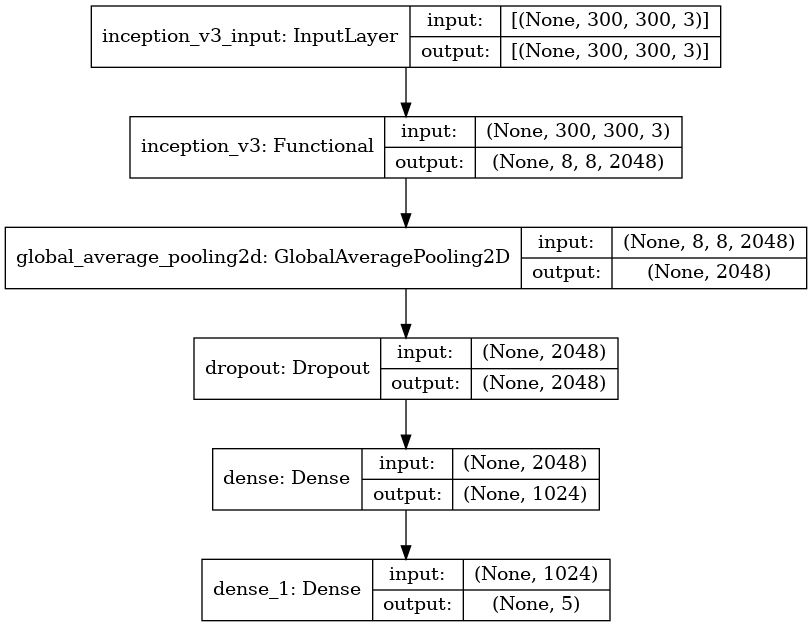

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# Setting variables for the model
batch_size = 32
epochs = 20

# Seperating Training and Testing Data
train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]

In [ ]:
# Calculating variables for the model
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 121
validation_steps : 13


In [ ]:
# File Path to store the trained models
filepath = "./model_{epoch:02d}-{val_accuracy:.2f}.h5"

# Using the ModelCheckpoint function to train and store all the best models
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint1]
# Training the Model
history = model.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=valid_generator, validation_steps=validation_steps,
                              callbacks=callbacks_list)

Epoch 1/20
121/121 [==============================] - 139s 1s/step - loss: 0.7765 - accuracy: 0.7193 - val_loss: 0.4867 - val_accuracy: 0.8341

Epoch 00001: val_accuracy improved from -inf to 0.83413, saving model to ./model_01-0.83.h5
Epoch 2/20
121/121 [==============================] - 96s 794ms/step - loss: 0.4750 - accuracy: 0.8345 - val_loss: 0.4711 - val_accuracy: 0.8197

Epoch 00002: val_accuracy did not improve from 0.83413
Epoch 3/20
121/121 [==============================] - 97s 806ms/step - loss: 0.4065 - accuracy: 0.8582 - val_loss: 0.4300 - val_accuracy: 0.8389

Epoch 00003: val_accuracy improved from 0.83413 to 0.83894, saving model to ./model_03-0.84.h5
Epoch 4/20
121/121 [==============================] - 97s 805ms/step - loss: 0.3939 - accuracy: 0.8633 - val_loss: 0.4035 - val_accuracy: 0.8462

Epoch 00004: val_accuracy improved from 0.83894 to 0.84615, saving model to ./model_04-0.85.h5
Epoch 5/20
121/121 [==============================] - 97s 802ms/step - loss: 0.36

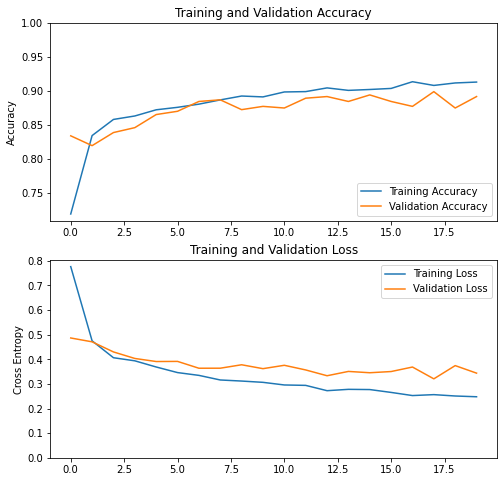

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Calculate the Loss and Accuracy on the Validation Data
test_loss, test_acc = model.evaluate(valid_generator)
print('test accuracy : ', test_acc)

14/14 [==============================] - 5s 337ms/step - loss: 0.3561 - accuracy: 0.8907
test accuracy :  0.8906976580619812


In [ ]:
# Check our folder and import the model with best validation accuracy
loaded_best_model = keras.models.load_model("./model_18-0.90.h5")

# Custom function to load and predict label for the image
def predict(img_rel_path):
    # Import Image from the path with size of (300, 300)
    img = image.load_img(img_rel_path, target_size=(300, 300))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = loaded_best_model.predict(img[np.newaxis, ...])

    # Label array
    labels = {0: 'daisy', 1: 'dandelion', 2: 'rose', 3: 'sunflower', 4: 'tulip'}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))

    def plot_bar_x():
        # this is for plotting purpose
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()
    plot_bar_x()

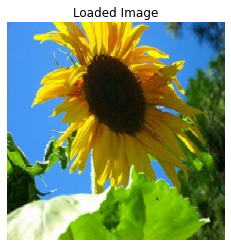



Maximum Probability:  0.96926737
Classified: sunflower 



-------------------Individual Probability--------------------------------

DAISY : 0.59 %
DANDELION : 2.45 %
ROSE : 0.01 %
SUNFLOWER : 96.93 %
TULIP : 0.02 %


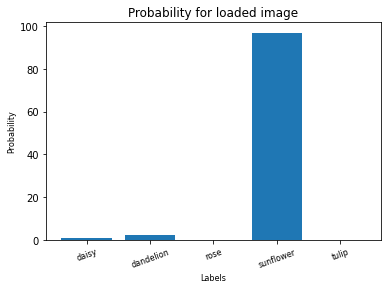

In [ ]:
# Unseen Dataset
predict("../input/flowers-dataset/test/Image_1.jpg")